In [1]:
#-- Paquetes --
import pandas as pd
import numpy as np
import random

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV 
from sklearn.svm import SVC as svc 
import sklearn.metrics as sklmt 
from scipy import stats
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
import seaborn as sns
from sklearn.neighbors import RadiusNeighborsClassifier

C:\Users\masoz\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\masoz\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def PR_curve(model, X_test, y_test, titulo):
    from sklearn.metrics import precision_recall_curve, accuracy_score, auc
    from matplotlib import pyplot
    import numpy as np

    # predict probabilities
    yhat = model.predict_proba(X_test)
    
    # keep probabilities for the positive outcome only
    yhat = yhat[:, 1]
    
    # calculate pr-curve
    precision, recall, thresholds = precision_recall_curve(y_test, yhat)
    
    # convert to f score
    numerator = 2 * recall * precision
    denom = recall + precision
    fscore = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom != 0))
    
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    
    # Compute predictions based on the threshold that maximizes F-Score
    y_pred = np.where(yhat >= thresholds[ix], 1, 0)
    
    # Compute accuracy using the predictions
    accuracy = accuracy_score(y_test, y_pred)
    
    # Compute AUC
    auc_score = auc(recall, precision)
    
    # Generate dummy data for a perfect model
    y_true = np.array([1, 1, 1, 1, 1, 1, 1, 1])
    y_scores = np.array([1, 1, 1, 1, 1, 1, 1, 1])
    # Compute precision and recall values using scikit-learn's precision_recall_curve
    precision_perfect, recall_perfect, _ = precision_recall_curve(y_true, y_scores)

    # Plot the precision-recall curve
    pyplot.plot(recall_perfect, precision_perfect, linestyle='--', color='green', lw=2, label='Perfect model')
    pyplot.plot(recall, precision, marker='.', label='Random Forest', color='hotpink')
    pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')

    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.legend(fontsize='small')
    pyplot.title(titulo)
    
    # show the plot
    pyplot.show()
    print('Best Threshold=%f, F-Score=%.3f, Accuracy=%.3f, AUC=%.3f' % (thresholds[ix], fscore[ix], accuracy, auc_score))
    return thresholds[ix], fscore[ix], accuracy, auc_score


In [3]:
def leer_lista(nombre_archivo):
    with open(nombre_archivo, 'r') as file:
        return [line.strip() for line in file]

In [6]:
# Cargar muestra positiva
genes = pd.read_csv(r"..\Archivos\Genes_entrenamiento\Genes_cadena.csv",
                   sep = ',')
# Filtrar el DataFrame para seleccionar las filas que cumplan la condición
filas_seleccionadas = genes[genes['Usar para entrenar'] == 'si']
# Obtener los valores de la columna 'WBID' para las filas seleccionadas
muestra_positiva = filas_seleccionadas['WBID'].tolist()

#Cargar dataset
dataset_RNAseq_bulk = pd.read_csv(r"..\Archivos\Datasets_normalizados\boeck_gomez_kalesky_mirza_tmm.csv",
                                 index_col=0)

In [7]:
dataset_RNAseq_bulk


,N2_4cell_EE_RZ.56_dcpm,N2_EE_50.0_dcpm,N2_EE_50.30_dcpm,N2_EE_50.60_dcpm,N2_EE_50.210_dcpm,N2_EE_50.240_dcpm,N2_EE_50.300_dcpm,N2_EE_50.330_dcpm,N2_EE_50.360_dcpm,N2_EE_50.390_dcpm,...,Bsub_20,Bsub_25,Muscle,Intestine,Neurons,Hypodermis,CF18_KO_6h,CF18_WT_6h,CF18_KO_4h,CF18_WT_4h
Gene,,,,,,,,,,,,,,,,,,,,,
WBGene00000001,100.714593,36.980422,45.156518,45.058099,34.168967,18.208577,31.537190,30.838041,50.667133,42.264209,...,92.186850,93.127281,1.880153,1.571226,3.499714,3.015830,23.545448,23.879023,22.861651,22.935980
WBGene00000002,0.895805,0.426002,1.030835,1.458889,6.720474,4.615708,57.043095,80.462182,26.396561,47.347395,...,5.751826,6.772925,0.439783,0.694218,1.620363,0.520771,15.460457,12.841540,15.321141,15.888823
WBGene00000003,2.205310,3.050863,2.847775,1.734292,8.289109,7.803676,43.027247,51.838023,28.131643,39.257216,...,5.989989,5.206053,2.510840,1.325491,0.784505,1.012140,40.756174,30.529294,39.682579,33.538325
WBGene00000004,6.446542,21.102163,27.161397,30.938133,97.764272,110.092461,249.248201,271.800314,422.903907,317.885545,...,29.025489,35.059019,2.118224,1.076804,3.517933,3.666870,107.395527,78.677221,109.025817,80.455536
WBGene00000005,0.260598,0.064546,0.140906,0.230743,3.478278,0.541107,5.608789,5.072151,9.604672,8.320867,...,4.267015,5.993298,2.612652,0.359007,0.123121,0.362405,5.623859,2.487146,5.307832,2.073609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WBGene00306081,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.025095,0.142845,0.009948,0.218514,0.404109,0.188145,0.229592,0.136108
WBGene00306121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.177745,0.808473,0.197739,0.193027,1.004787,0.366116,2.077860,3.275180,1.897119,2.999726
WBGene00306123,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.313565,0.234346,0.047963,0.038216,0.365242,0.027726,1.487020,1.915791,1.495905,2.097287


In [8]:
def leer_lista(nombre_archivo):
    with open(nombre_archivo, 'r') as file:
        return [line.strip() for line in file]

# Leer las listas desde los archivos de texto
X_test = leer_lista(r"..\Archivos\Genes_entrenamiento\X_test.txt")
X_train = leer_lista(r"..\Archivos\Genes_entrenamiento\X_train.txt")
entrenamiento = X_test + X_train

In [9]:
positivos_sc1 = []
positivos_sc2 = []
positivos_sc3 = []
positivos_sc4 = []
positivos_sc5 = []

for i in genes.index:
        complejo = genes.loc[i,'Complejo'] 
        if complejo == 'I' and genes.loc[i,'Usar para entrenar'] == 'si':
            positivos_sc1.append(genes.loc[i,'WBID'])
        elif complejo == 'II' and genes.loc[i,'Usar para entrenar'] == 'si':
            positivos_sc2.append(genes.loc[i,'WBID'])
        elif complejo == 'III' and genes.loc[i,'Usar para entrenar'] == 'si':
            positivos_sc3.append(genes.loc[i,'WBID'])
        elif complejo == 'IV' and genes.loc[i,'Usar para entrenar'] == 'si':
            positivos_sc4.append(genes.loc[i,'WBID'])
        elif complejo == 'V' and genes.loc[i,'Usar para entrenar'] == 'si':
            positivos_sc5.append(genes.loc[i,'WBID'])

In [10]:
def filtrar_datos(x_train, x_test, positivos_a_eliminar):
    # Filtrar las observaciones y las etiquetas de entrenamiento
    x_train_filtrado = []

    for observacion in x_train:
        if observacion not in positivos_a_eliminar:
            x_train_filtrado.append(observacion)

    # Filtrar las observaciones y las etiquetas de prueba
    x_test_filtrado = []

    for observacion in x_test:
        if observacion not in positivos_a_eliminar:
            x_test_filtrado.append(observacion)

    return x_train_filtrado, x_test_filtrado


In [11]:
#Nota: Acá solo estoy sacando observaciones de la clase positiva. Puede quedar desbalanceado. A chequear. 
X_train_sc1_genes, X_test_sc1_genes = filtrar_datos(X_train, X_test, positivos_sc1)
X_train_sc2_genes, X_test_sc2_genes = filtrar_datos(X_train, X_test, positivos_sc2)
X_train_sc3_genes, X_test_sc3_genes = filtrar_datos(X_train, X_test, positivos_sc3)
X_train_sc4_genes, X_test_sc4_genes = filtrar_datos(X_train, X_test, positivos_sc4)
X_train_sc5_genes, X_test_sc5_genes = filtrar_datos(X_train, X_test, positivos_sc5)

In [13]:
def vectores_entrenar(X_train_genes, X_test_genes, df):
    datos_train_test = {'train': {}, 'test': {}}
    
    X_train_vector = df[df.index.isin(X_train_genes)].values
    datos_train_test['train']['data'] = X_train_vector
    X_test_vector = df[df.index.isin(X_test_genes)].values
    datos_train_test['test']['data'] = X_test_vector
    
    genes_train = df.index[df.index.isin(X_train_genes)]
    print(len(genes_train))
    datos_train_test['train']['classes'] = [1 if gen in muestra_positiva else 0 for gen in genes_train]
    print(len(datos_train_test['train']['classes']))
    genes_test = df.index[df.index.isin(X_test_genes)]
    datos_train_test['test']['classes'] = [1 if gen in muestra_positiva else 0 for gen in genes_test]
    return datos_train_test

In [15]:
dic_all = vectores_entrenar(X_train, X_test, dataset_RNAseq_bulk)

dic_sc1 = vectores_entrenar(X_train_sc1_genes, X_test_sc1_genes, dataset_RNAseq_bulk)
dic_sc2 = vectores_entrenar(X_train_sc2_genes, X_test_sc2_genes, dataset_RNAseq_bulk)
dic_sc3 = vectores_entrenar(X_train_sc3_genes, X_test_sc3_genes, dataset_RNAseq_bulk)
dic_sc4 = vectores_entrenar(X_train_sc4_genes, X_test_sc4_genes, dataset_RNAseq_bulk)
dic_sc5 = vectores_entrenar(X_train_sc5_genes, X_test_sc5_genes, dataset_RNAseq_bulk)


102
102
78
78
100
100
98
98
92
92
93
93


In [17]:
dic_todos = {'all': dic_all,
            'sc1': dic_sc1,
            'sc2': dic_sc2,
            'sc3': dic_sc3,
            'sc4': dic_sc4,
            'sc5': dic_sc5}

In [18]:
# Definir la cuadrícula de hiperparámetros a explorar
param_grid = {
    'n_estimators': np.arange(1, 15, 1),
    'max_depth': np.arange(1, 20, 2),
    'min_samples_split': np.arange(2, 20, 2),
    'min_samples_leaf': np.arange(1, 15, 1)
}
param_grid

{'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
 'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
 'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])}

In [19]:
modelos = {}

In [19]:
# Definir el modelo RandomForest
modelo_rf = RandomForestClassifier(random_state=42)

for nombre_df, datos in dic_todos.items():
    # Obtener los datos de entrenamiento y las clases correspondientes
    X_train = datos['train']['data']
    y_train = datos['train']['classes']
    
    modelos[nombre_df + '_RF'] = {'modelo': '', 
                                   'X_test': '', 
                                   'y_test': '', 
                                   'X_train': '', 
                                   'y_train': '', 
                                   'accuracy': '', 
                                   'f1': '',
                                'threshold': ''}        
    # Inicializar y entrenar el modelo Random Forest
    grid_search = GridSearchCV(estimator=modelo_rf, param_grid=param_grid, n_jobs= 4 , cv=5, scoring='f1')

    # Entrenar GridSearchCV en los datos de entrenamiento
    grid_search.fit(X_train, y_train)
    
    # Guardar el modelo entrenado en el diccionario de modelos_rf_por_df
    modelos[nombre_df + '_RF']['modelo'] = grid_search
    
    mejores_parametros = grid_search.best_params_
    mejor_puntaje = grid_search.best_score_
    
    # Imprimir los mejores parámetros y el mejor puntaje
    print(f"Best F1 score: {mejor_puntaje:.3f} with hyperparameters: {mejores_parametros}") 

    # Predecir las clases para el conjunto de prueba y calcular la precisión
    X_test = datos['test']['data']
    y_test = datos['test']['classes']
    y_pred = grid_search.predict(X_test)
    
    accuracy = sklmt.accuracy_score(y_test, y_pred)
    f1 = sklmt.f1_score(y_test, y_pred, average = 'binary', pos_label= 1)
    
#     modelos[nombre_df + '_RF']['accuracy'] = accuracy
#     modelos[nombre_df + '_RF']['f1'] = f1
    modelos[nombre_df + '_RF']['X_train'] = X_train
    modelos[nombre_df + '_RF']['y_train'] = y_train
    modelos[nombre_df + '_RF']['X_test'] = X_test
    modelos[nombre_df + '_RF']['y_test'] = y_test
    
    print(f"Precision del modelo para el DataFrame {nombre_df}: {accuracy}")
    print(f"F1 del modelo para el DataFrame {nombre_df}: {f1}")

Best F1 score: 0.979 with hyperparameters: {'min_samples_leaf': 3, 'n_estimators': 3}
Precision del modelo para el DataFrame all: 0.9411764705882353
F1 del modelo para el DataFrame all: 0.9500000000000001
Best F1 score: 0.960 with hyperparameters: {'min_samples_leaf': 1, 'n_estimators': 3}
Precision del modelo para el DataFrame sc1: 0.9047619047619048
F1 del modelo para el DataFrame sc1: 0.8333333333333334
Best F1 score: 0.970 with hyperparameters: {'min_samples_leaf': 1, 'n_estimators': 6}
Precision del modelo para el DataFrame sc2: 0.96875
F1 del modelo para el DataFrame sc2: 0.9714285714285714
Best F1 score: 0.978 with hyperparameters: {'min_samples_leaf': 2, 'n_estimators': 3}
Precision del modelo para el DataFrame sc3: 0.9393939393939394
F1 del modelo para el DataFrame sc3: 0.9473684210526316
Best F1 score: 0.973 with hyperparameters: {'min_samples_leaf': 1, 'n_estimators': 3}
Precision del modelo para el DataFrame sc4: 0.9411764705882353
F1 del modelo para el DataFrame sc4: 0.947

In [20]:
param_grid= {'rbf_svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                 "rbf_svm__C": np.arange(0.1, 10, 1),
                 "rbf_svm__gamma": np.arange(0.01, 10, 1)}
param_grid

{'rbf_svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
 'rbf_svm__C': array([0.1, 1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1]),
 'rbf_svm__gamma': array([0.01, 1.01, 2.01, 3.01, 4.01, 5.01, 6.01, 7.01, 8.01, 9.01])}

In [21]:
# Definir el modelo SVM
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.neighbors import RadiusNeighborsClassifier


steps = [('scaler', StandardScaler()), ('rbf_svm', svc(probability=True))]
pipeline = Pipeline(steps)


for nombre_df, datos in dic_todos.items():
    # Obtener los datos de entrenamiento y las clases correspondientes
    X_train = datos['train']['data']
    y_train = datos['train']['classes']
    
    modelos[nombre_df + '_SVM'] = {'modelo': '', 
                                   'X_test': '', 
                                   'y_test': '', 
                                   'X_train': '', 
                                   'y_train': '', 
                                   'accuracy': '', 
                                   'f1': '',
                                'threshold': ''}    
    # Inicializar y entrenar el modelo Random Forest
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs= 4 , cv=5, scoring='f1')

    # Entrenar GridSearchCV en los datos de entrenamiento
    grid_search.fit(X_train, y_train)
    
    # Guardar el modelo entrenado en el diccionario de modelos_rf_por_df
    modelos[nombre_df + '_SVM']['modelo'] = grid_search
    
    mejores_parametros = grid_search.best_params_
    mejor_puntaje = grid_search.best_score_
    
    # Imprimir los mejores parámetros y el mejor puntaje
    print(f"Best F1 score: {mejor_puntaje:.3f} with hyperparameters: {mejores_parametros}") 

    # Predecir las clases para el conjunto de prueba y calcular la precisión
    X_test = datos['test']['data']
    y_test = datos['test']['classes']
    y_pred = grid_search.predict(X_test)
    
    accuracy = sklmt.accuracy_score(y_test, y_pred)
    f1 = sklmt.f1_score(y_test, y_pred, average = 'binary', pos_label= 1)

    modelos[nombre_df + '_SVM']['X_train'] = X_train
    modelos[nombre_df + '_SVM']['y_train'] = y_train
    modelos[nombre_df + '_SVM']['X_test'] = X_test
    modelos[nombre_df + '_SVM']['y_test'] = y_test
    
    print(f"Precision del modelo para el DataFrame {nombre_df}: {accuracy}")
    print(f"F1 del modelo para el DataFrame {nombre_df}: {f1}")

Best F1 score: 0.974 with hyperparameters: {'rbf_svm__C': 3.1, 'rbf_svm__gamma': 0.01, 'rbf_svm__kernel': 'linear'}
Precision del modelo para el DataFrame all: 0.9705882352941176
F1 del modelo para el DataFrame all: 0.9743589743589743
Best F1 score: 0.954 with hyperparameters: {'rbf_svm__C': 1.1, 'rbf_svm__gamma': 0.01, 'rbf_svm__kernel': 'linear'}
Precision del modelo para el DataFrame sc1: 0.9047619047619048
F1 del modelo para el DataFrame sc1: 0.8333333333333334
Best F1 score: 0.974 with hyperparameters: {'rbf_svm__C': 3.1, 'rbf_svm__gamma': 0.01, 'rbf_svm__kernel': 'linear'}
Precision del modelo para el DataFrame sc2: 0.96875
F1 del modelo para el DataFrame sc2: 0.9714285714285714
Best F1 score: 0.971 with hyperparameters: {'rbf_svm__C': 3.1, 'rbf_svm__gamma': 0.01, 'rbf_svm__kernel': 'linear'}
Precision del modelo para el DataFrame sc3: 0.9696969696969697
F1 del modelo para el DataFrame sc3: 0.972972972972973
Best F1 score: 0.968 with hyperparameters: {'rbf_svm__C': 3.1, 'rbf_svm_

In [22]:
param_grid = {'knn__n_neighbors': np.arange(2, 10, 1), 
              'knn__weights': ['uniform', 'distance'],
              'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'knn__leaf_size':  np.arange(1, 100, 10)}
param_grid

{'knn__n_neighbors': array([2, 3, 4, 5, 6, 7, 8, 9]),
 'knn__weights': ['uniform', 'distance'],
 'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
 'knn__leaf_size': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])}

In [23]:
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier


steps = [('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]
pipeline = Pipeline(steps)


for nombre_df, datos in dic_todos.items():
    # Obtener los datos de entrenamiento y las clases correspondientes
    X_train = datos['train']['data']
    y_train = datos['train']['classes']
    
    modelos[nombre_df + '_KNN'] = {'modelo': '', 
                                   'X_test': '', 
                                   'y_test': '', 
                                   'X_train': '', 
                                   'y_train': '', 
                                   'accuracy': '', 
                                   'f1': '',
                                'threshold': ''}
    
    # Inicializar y entrenar el modelo Random Forest
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs= 4 , cv=5, scoring='f1')

    # Entrenar GridSearchCV en los datos de entrenamiento
    grid_search.fit(X_train, y_train)
    
    # Guardar el modelo entrenado en el diccionario de modelos_rf_por_df
    modelos[nombre_df + '_KNN']['modelo'] = grid_search
    
    mejores_parametros = grid_search.best_params_
    mejor_puntaje = grid_search.best_score_
    
    # Imprimir los mejores parámetros y el mejor puntaje
    print(f"Best F1 score: {mejor_puntaje:.3f} with hyperparameters: {mejores_parametros}") 

    # Predecir las clases para el conjunto de prueba y calcular la precisión
    X_test = datos['test']['data']
    y_test = datos['test']['classes']
    y_pred = grid_search.predict(X_test)
    
    accuracy = sklmt.accuracy_score(y_test, y_pred)
    f1 = sklmt.f1_score(y_test, y_pred, average = 'binary', pos_label= 1)

    modelos[nombre_df + '_KNN']['X_train'] = X_train
    modelos[nombre_df + '_KNN']['y_train'] = y_train
    modelos[nombre_df + '_KNN']['X_test'] = X_test
    modelos[nombre_df + '_KNN']['y_test'] = y_test
    
    print(f"Precision del modelo para el DataFrame {nombre_df}: {accuracy}")
    print(f"F1 del modelo para el DataFrame {nombre_df}: {f1}")

Best F1 score: 0.974 with hyperparameters: {'knn__algorithm': 'auto', 'knn__leaf_size': 1, 'knn__n_neighbors': 4, 'knn__weights': 'uniform'}
Precision del modelo para el DataFrame all: 0.8823529411764706
F1 del modelo para el DataFrame all: 0.9
Best F1 score: 0.960 with hyperparameters: {'knn__algorithm': 'auto', 'knn__leaf_size': 1, 'knn__n_neighbors': 5, 'knn__weights': 'distance'}
Precision del modelo para el DataFrame sc1: 0.9047619047619048
F1 del modelo para el DataFrame sc1: 0.8333333333333334
Best F1 score: 0.974 with hyperparameters: {'knn__algorithm': 'auto', 'knn__leaf_size': 1, 'knn__n_neighbors': 2, 'knn__weights': 'distance'}
Precision del modelo para el DataFrame sc2: 0.96875
F1 del modelo para el DataFrame sc2: 0.9714285714285714
Best F1 score: 0.971 with hyperparameters: {'knn__algorithm': 'auto', 'knn__leaf_size': 1, 'knn__n_neighbors': 2, 'knn__weights': 'distance'}
Precision del modelo para el DataFrame sc3: 0.9393939393939394
F1 del modelo para el DataFrame sc3: 0.

In [24]:
#chequeamos los modelos entrenados
modelos_nombres = list(modelos.keys())
print(modelos_nombres)
modelos['all_RF'].keys()

['all_RF',
 'sc1_RF',
 'sc2_RF',
 'sc3_RF',
 'sc4_RF',
 'sc5_RF',
 'all_SVM',
 'sc1_SVM',
 'sc2_SVM',
 'sc3_SVM',
 'sc4_SVM',
 'sc5_SVM',
 'all_KNN',
 'sc1_KNN',
 'sc2_KNN',
 'sc3_KNN',
 'sc4_KNN',
 'sc5_KNN']

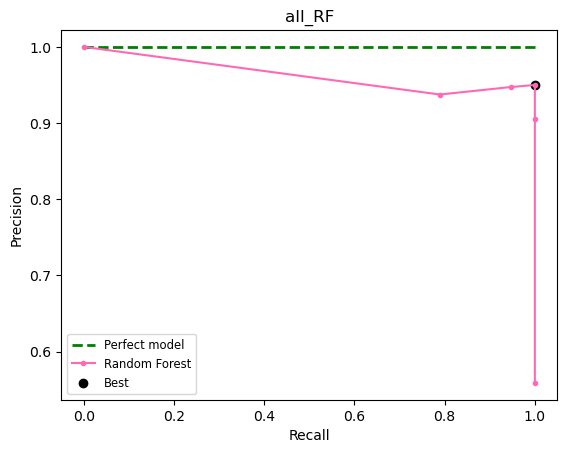

Best Threshold=0.777778, F-Score=0.974, Accuracy=0.971, AUC=0.964


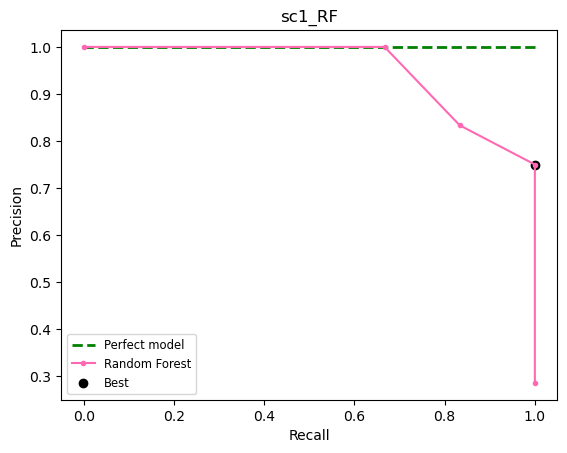

Best Threshold=0.333333, F-Score=0.857, Accuracy=0.905, AUC=0.951


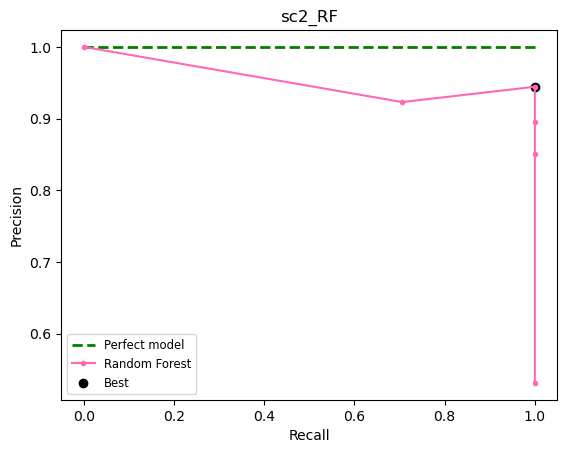

Best Threshold=0.833333, F-Score=0.971, Accuracy=0.969, AUC=0.953


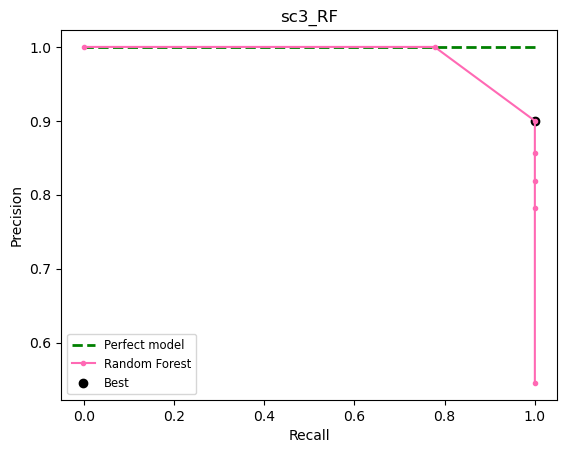

Best Threshold=0.750000, F-Score=0.947, Accuracy=0.939, AUC=0.989


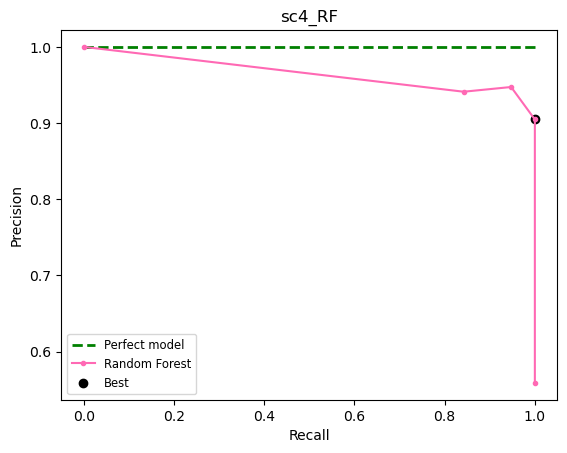

Best Threshold=0.333333, F-Score=0.950, Accuracy=0.941, AUC=0.965


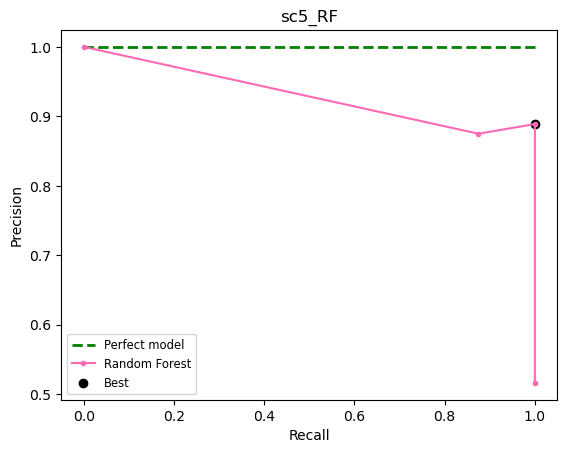

Best Threshold=0.666667, F-Score=0.941, Accuracy=0.935, AUC=0.931


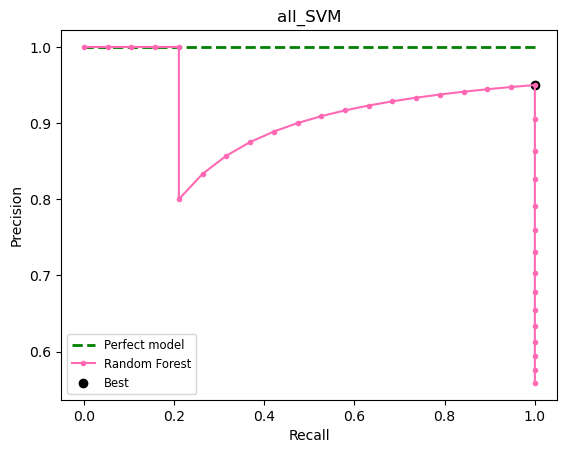

Best Threshold=0.487963, F-Score=0.974, Accuracy=0.971, AUC=0.927


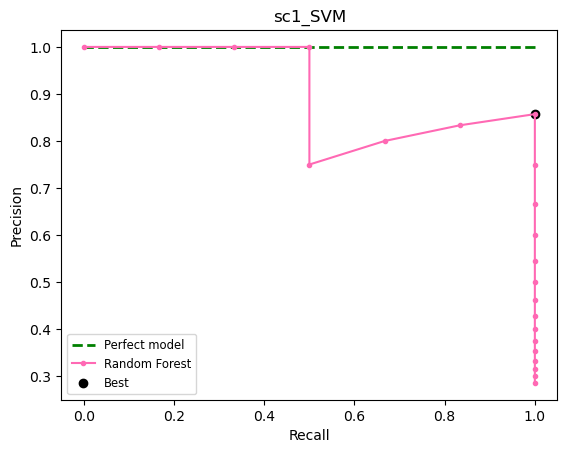

Best Threshold=0.160764, F-Score=0.923, Accuracy=0.952, AUC=0.906


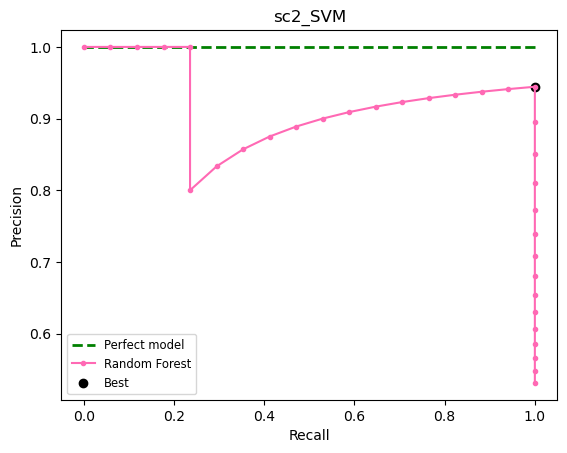

Best Threshold=0.447558, F-Score=0.971, Accuracy=0.969, AUC=0.924


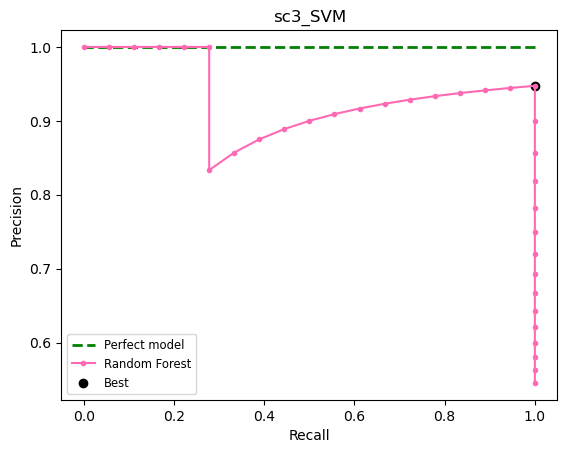

Best Threshold=0.500000, F-Score=0.973, Accuracy=0.970, AUC=0.936


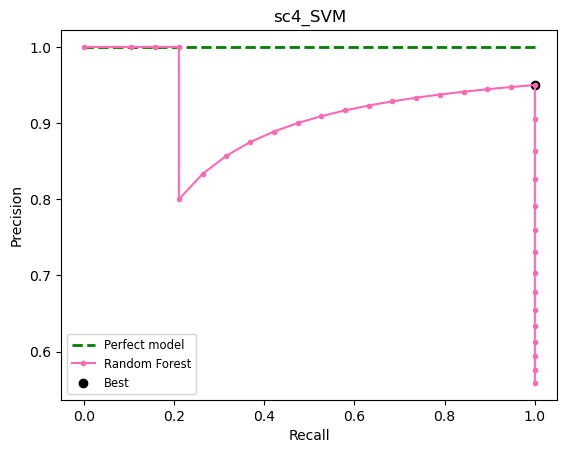

Best Threshold=0.530732, F-Score=0.974, Accuracy=0.971, AUC=0.927


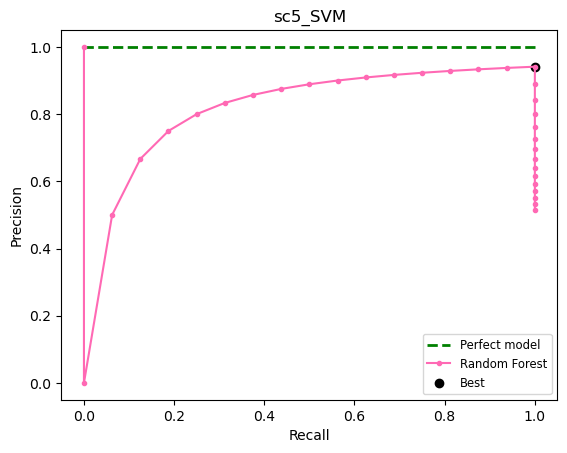

Best Threshold=0.423838, F-Score=0.970, Accuracy=0.968, AUC=0.818


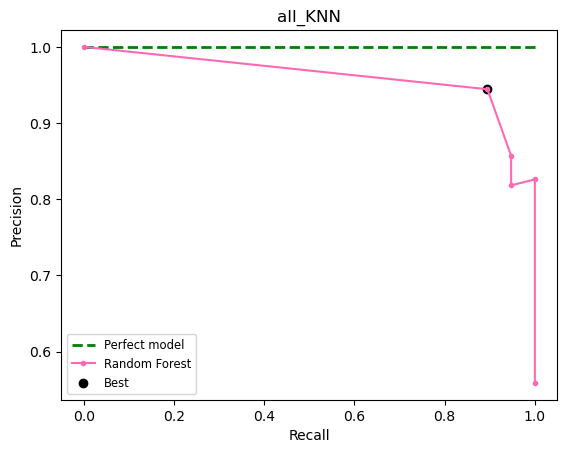

Best Threshold=1.000000, F-Score=0.919, Accuracy=0.912, AUC=0.961


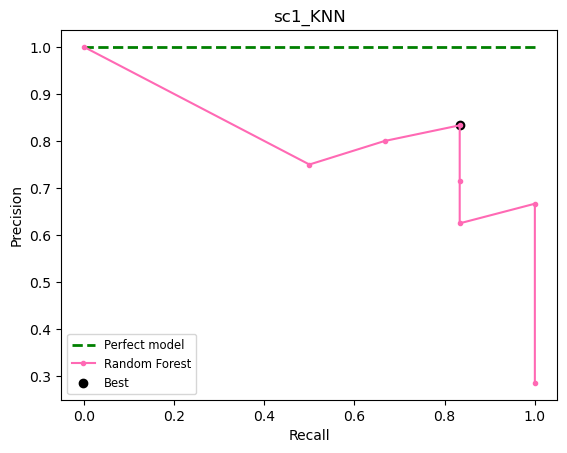

Best Threshold=0.617821, F-Score=0.833, Accuracy=0.905, AUC=0.810


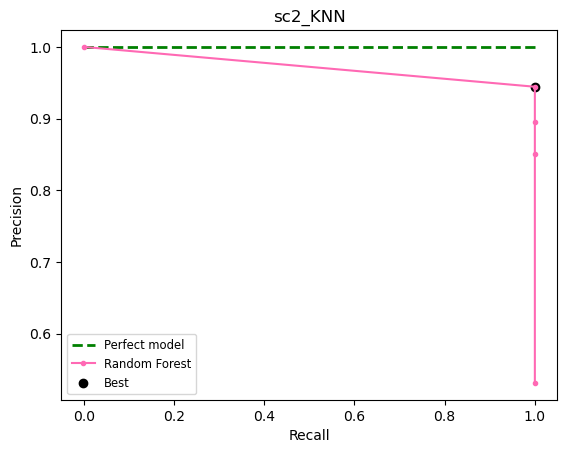

Best Threshold=1.000000, F-Score=0.971, Accuracy=0.969, AUC=0.972


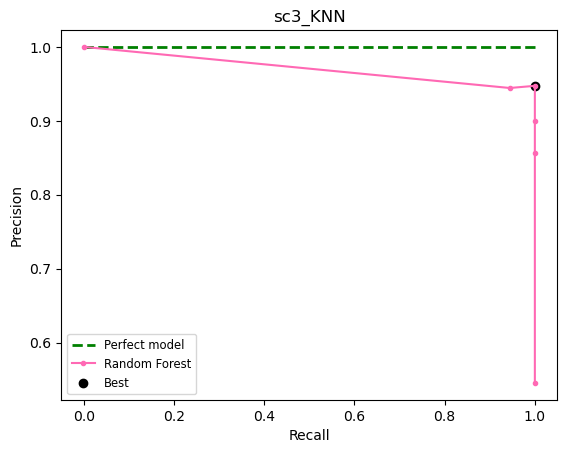

Best Threshold=0.486285, F-Score=0.973, Accuracy=0.970, AUC=0.971


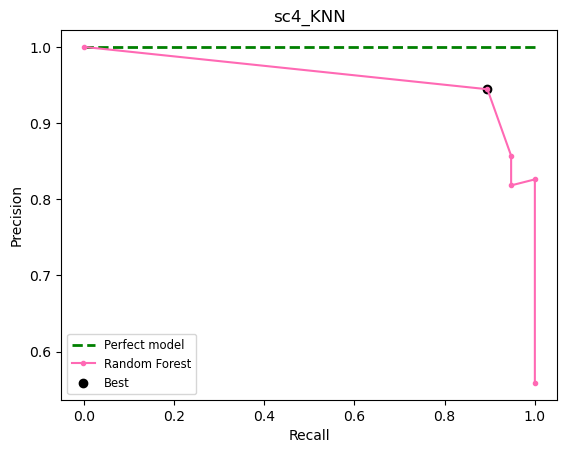

Best Threshold=1.000000, F-Score=0.919, Accuracy=0.912, AUC=0.961


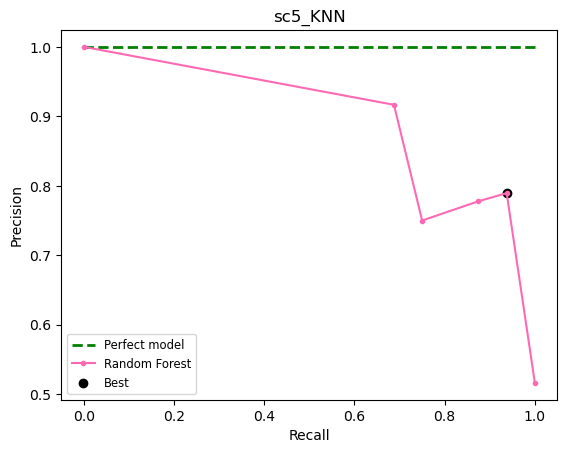

Best Threshold=0.250000, F-Score=0.857, Accuracy=0.839, AUC=0.896


In [25]:
# Crear una lista para almacenar los resultados
resultados = []


for nombre_modelo, datos in modelos.items():
        modelo = datos['modelo']
        X_test = datos['X_test']
        y_test = datos['y_test']
    
        # Calcular los resultados utilizando la función PR_curve
        th, f1, ac, auc = PR_curve(modelo, X_test, y_test, nombre_modelo)

        th = round(th, 2)
        f1 = round(f1, 2)
        ac = round(ac, 2)
        auc = round(auc, 2)
        
        modelos[nombre_modelo]['accuracy'] = ac
        modelos[nombre_modelo]['f1'] = f1
        modelos[nombre_modelo]['auc'] = auc
        modelos[nombre_modelo]['threshold'] = th
                   


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Function to filter models based on their keys
def filter_models(modelos, keyword):
    return {key: value for key, value in modelos.items() if key.endswith(keyword)}

# Function to plot precision-recall curves for a group of models
def plot_precision_recall(modelos, title):
    plt.figure(figsize=(6, 4))
    
    # Dummy data for a perfect model
    y_true = np.array([1, 1, 1, 1, 1, 1, 1, 1])
    y_scores = np.array([1, 1, 1, 1, 1, 1, 1, 1])
    precision_perfect, recall_perfect, _ = precision_recall_curve(y_true, y_scores)
    plt.plot(recall_perfect, precision_perfect, linestyle='--', color='darkgrey', lw=2, label='Perfect model')
    
    # Iterate over models
    for key in modelos.keys():
        model = modelos[key]['modelo']
        X_test = modelos[key]['X_test']
        y_test = modelos[key]['y_test']

        # Calculate probabilities
        y_probs = model.predict_proba(X_test)[:, 1]

        # Calculate precision-recall curve
        precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

        # Calculate F1 score
        fscore = np.zeros_like(precision)
        nonzero_idx = (precision + recall) > 0
        fscore[nonzero_idx] = (2 * precision[nonzero_idx] * recall[nonzero_idx]) / (precision[nonzero_idx] + recall[nonzero_idx])

        # Locate index of the largest F1 score
        ix = np.argmax(fscore)

        # Plot precision-recall curve
        label = f'{key} ({thresholds[ix]:.2f})'
        plt.plot(recall, precision, marker='.', label=label)

        # Plot best F1 score point
        plt.scatter(recall[ix], precision[ix], marker='o', color='black')

    # Axis labels
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(title, fontsize=14)

    # Set limits and legend
    plt.xlim([0.0, 1.02])
    plt.legend(fontsize=11, bbox_to_anchor=(1.1, -0.2), ncol=3)
    plt.show()


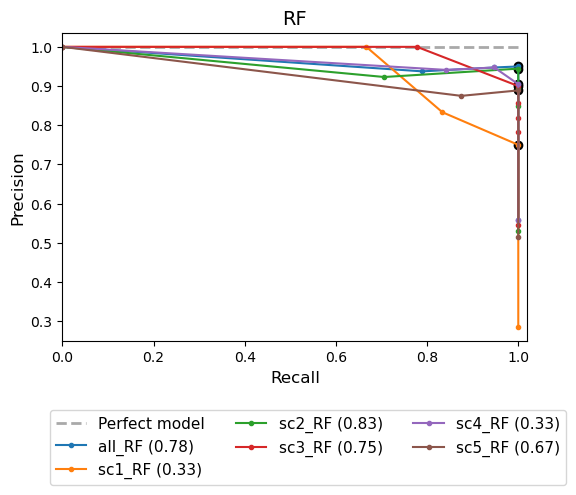

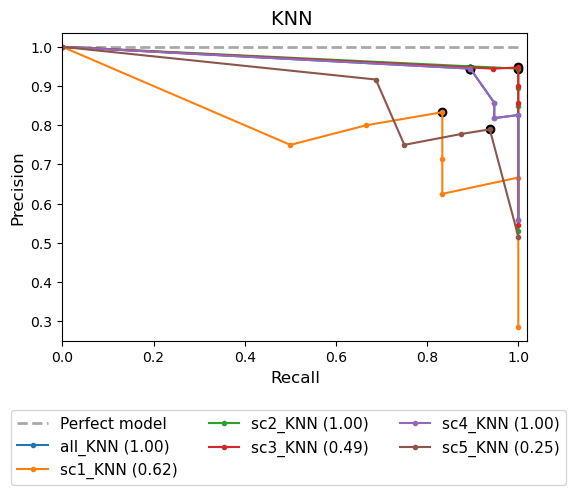

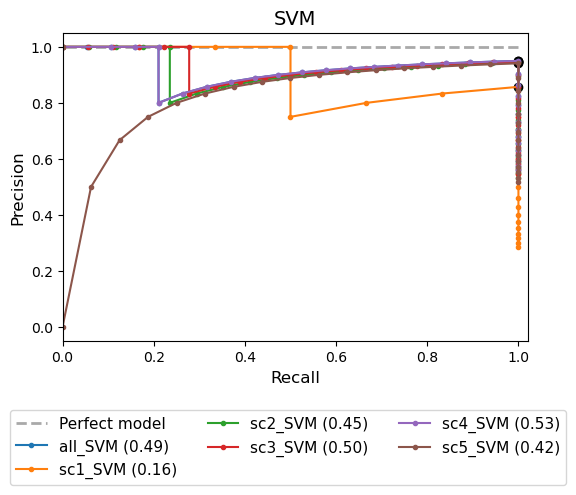

In [49]:

# Filter models ending with "RF" and plot
rf_models = filter_models(modelos, "RF")
plot_precision_recall(rf_models, "RF")

# Filter models ending with "KNN" and plot
knn_models = filter_models(modelos, "KNN")
plot_precision_recall(knn_models, "KNN ")

# Filter models ending with "SVM" and plot
svm_models = filter_models(modelos, "SVM")
plot_precision_recall(svm_models, "SVM")


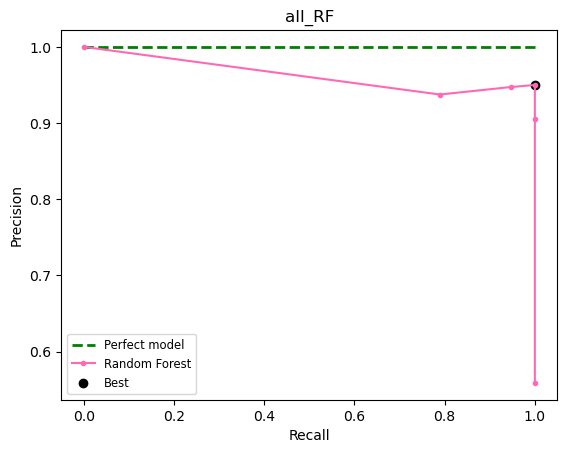

Best Threshold=0.777778, F-Score=0.974, Accuracy=0.971, AUC=0.964


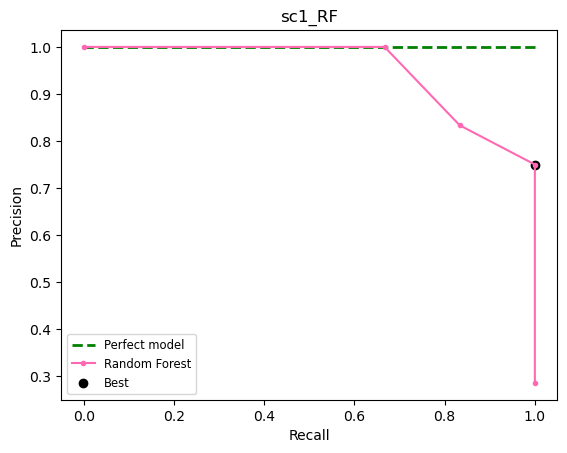

Best Threshold=0.333333, F-Score=0.857, Accuracy=0.905, AUC=0.951


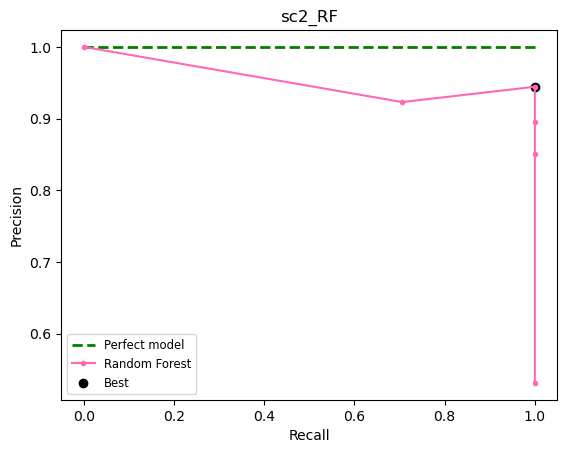

Best Threshold=0.833333, F-Score=0.971, Accuracy=0.969, AUC=0.953


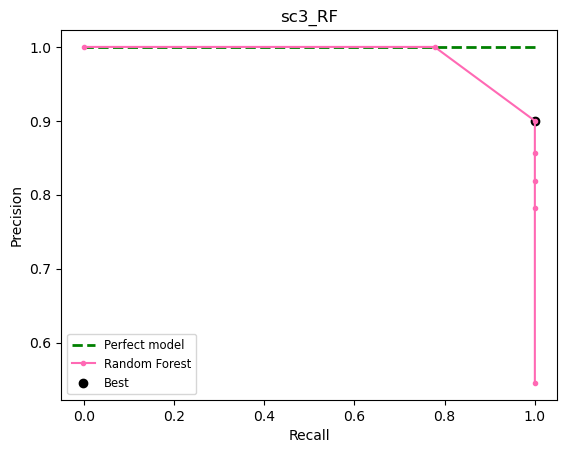

Best Threshold=0.750000, F-Score=0.947, Accuracy=0.939, AUC=0.989


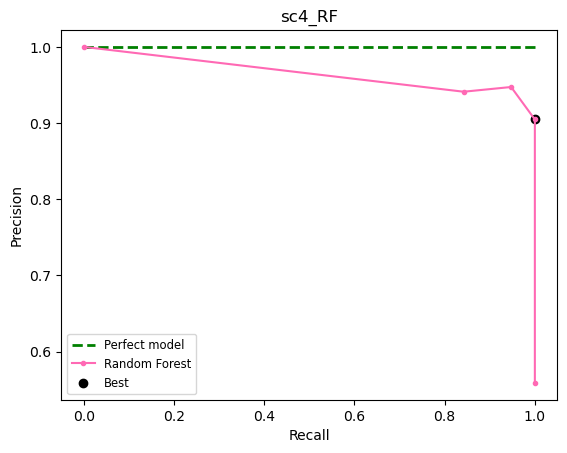

Best Threshold=0.333333, F-Score=0.950, Accuracy=0.941, AUC=0.965


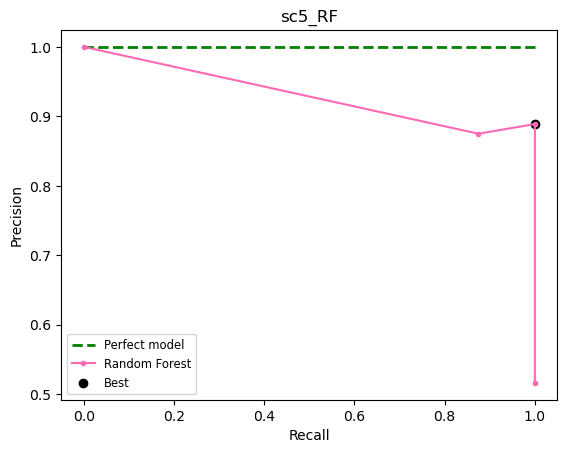

Best Threshold=0.666667, F-Score=0.941, Accuracy=0.935, AUC=0.931


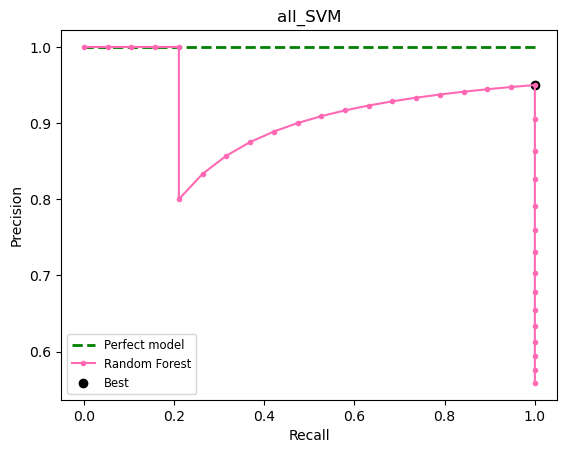

Best Threshold=0.529771, F-Score=0.974, Accuracy=0.971, AUC=0.927


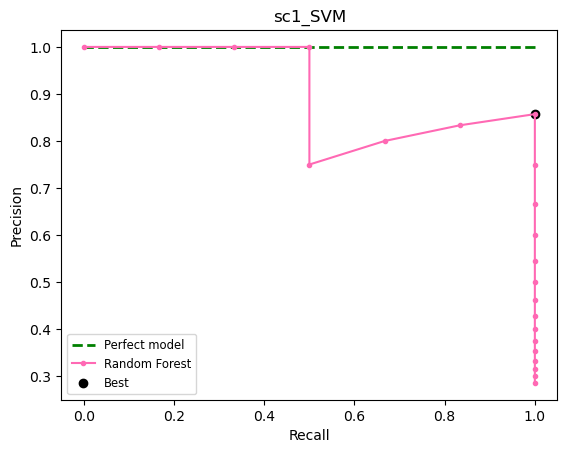

Best Threshold=0.130035, F-Score=0.923, Accuracy=0.952, AUC=0.906


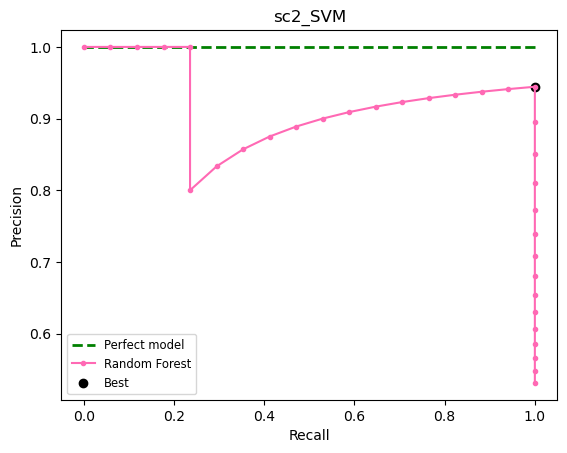

Best Threshold=0.448756, F-Score=0.971, Accuracy=0.969, AUC=0.924


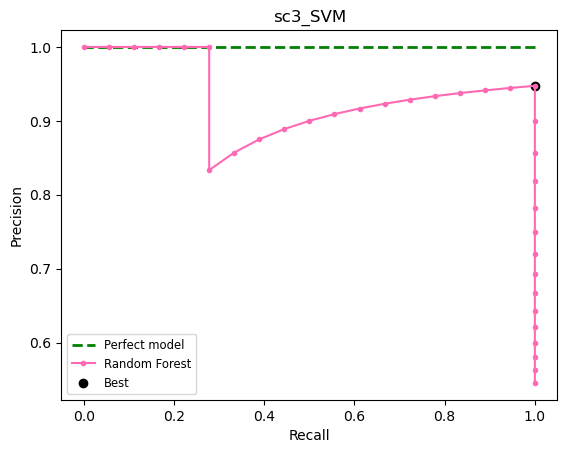

Best Threshold=0.479807, F-Score=0.973, Accuracy=0.970, AUC=0.936


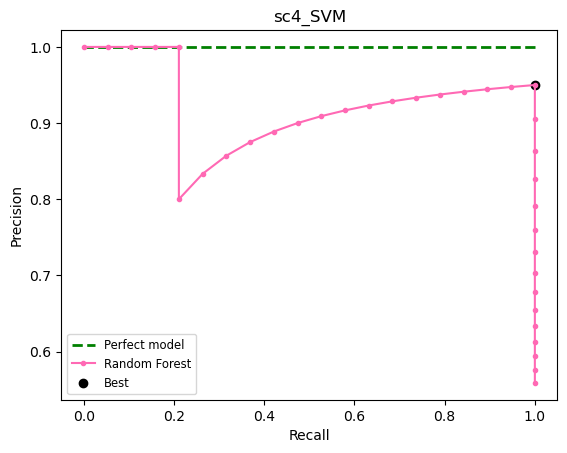

Best Threshold=0.462399, F-Score=0.974, Accuracy=0.971, AUC=0.927


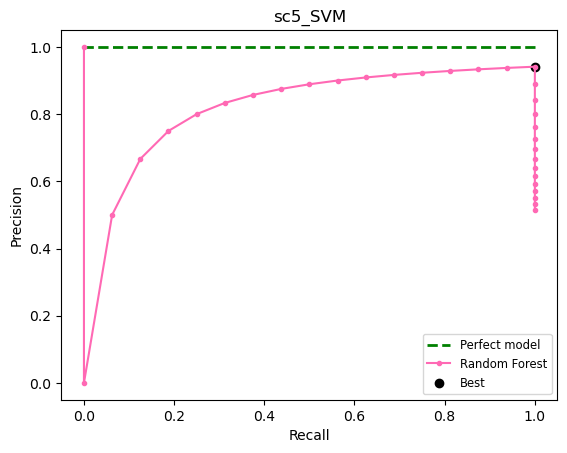

Best Threshold=0.379135, F-Score=0.970, Accuracy=0.968, AUC=0.818


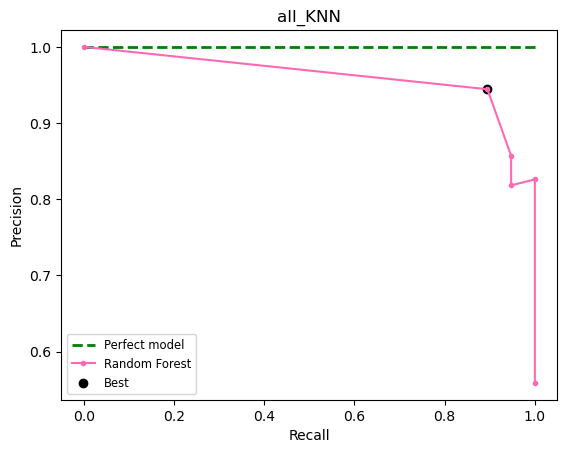

Best Threshold=1.000000, F-Score=0.919, Accuracy=0.912, AUC=0.961


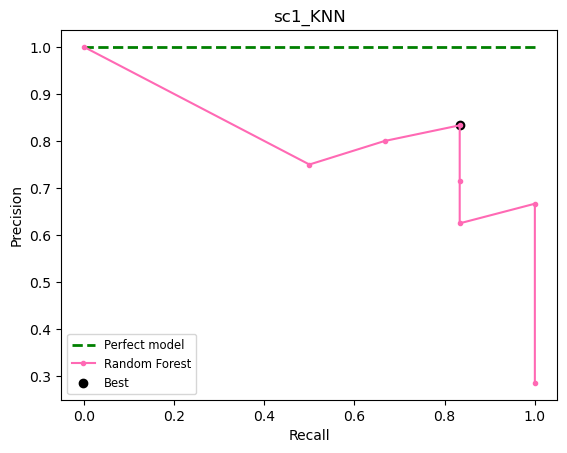

Best Threshold=0.617821, F-Score=0.833, Accuracy=0.905, AUC=0.810


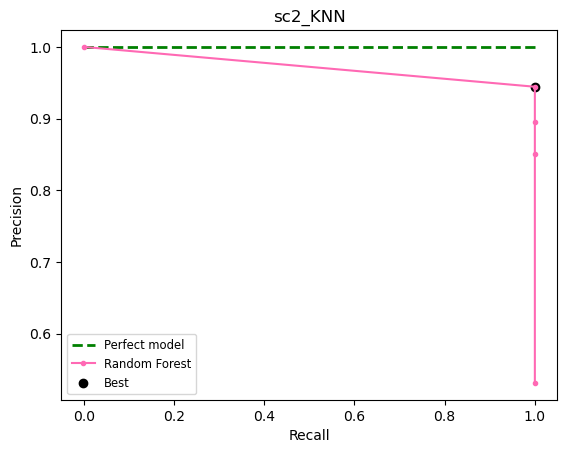

Best Threshold=1.000000, F-Score=0.971, Accuracy=0.969, AUC=0.972


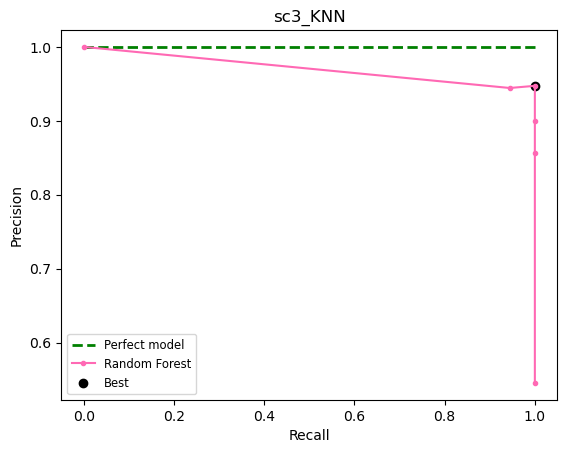

Best Threshold=0.486285, F-Score=0.973, Accuracy=0.970, AUC=0.971


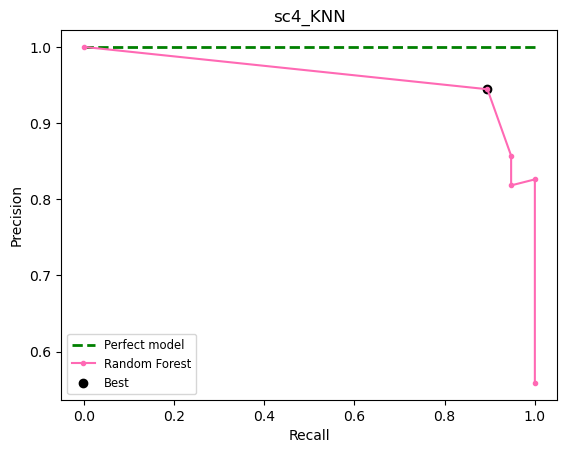

Best Threshold=1.000000, F-Score=0.919, Accuracy=0.912, AUC=0.961


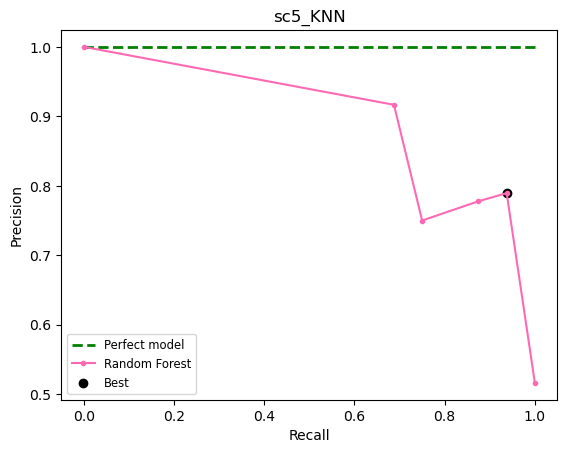

Best Threshold=0.250000, F-Score=0.857, Accuracy=0.839, AUC=0.896


In [15]:
# Crear una lista para almacenar los resultados
resultados = []

# Iterar sobre los datos
for nombre_df, datos in modelos.items():
    # Obtener los datos de entrenamiento y las clases correspondientes
    X_test = datos['X_test']
    y_test = datos['y_test']
    modelo = datos['modelo']
    
    # Calcular los resultados utilizando la función PR_curve
    th, f1, ac, auc = PR_curve(modelo, X_test, y_test, nombre_df)
    
    th = round(th, 2)
    f1 = round(f1, 2)
    ac = round(ac, 2)
    auc = round(auc, 2)
    
    # Agregar los resultados a la lista
    resultados.append([nombre_df, th, ac, f1, auc])

In [26]:
# Crear un DataFrame a partir de la lista de resultados
df_resultados = pd.DataFrame(resultados, columns=['nombre_df', 'threshold', 'Precisión', 'F1', 'AUC'])
df_resultados.set_index('nombre_df', inplace=True)

In [27]:
df_resultados

,threshold,Precisión,F1,AUC
nombre_df,,,,
all_RF,0.78,0.97,0.97,0.96
sc1_RF,0.33,0.90,0.86,0.95
sc2_RF,0.83,0.97,0.97,0.95
sc3_RF,0.75,0.94,0.95,0.99
sc4_RF,0.33,0.94,0.95,0.97
sc5_RF,0.67,0.94,0.94,0.93
all_SVM,0.53,0.97,0.97,0.93
sc1_SVM,0.13,0.95,0.92,0.91
sc2_SVM,0.45,0.97,0.97,0.92


In [30]:
df_resultados.to_csv('../Archivos/resultado_metricas_entrenamiento.csv')

In [21]:
df_resultados.columns

Index(['threshold', 'Precisión', 'F1', 'AUC'], dtype='object')

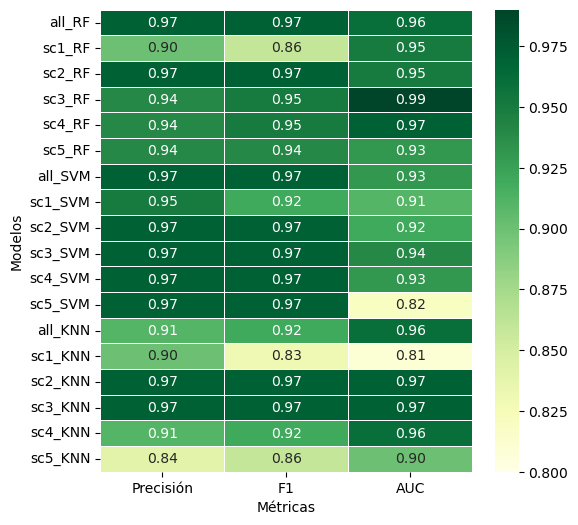

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

#
# Eliminar la columna 'threshold' del dataframe
df_resultados_sin_threshold = df_resultados.drop(columns=['threshold'])

# Definir el rango de colores personalizado
cmap = sns.mpl_palette("YlGn", as_cmap=True)

# Generar el heatmap con el rango de colores personalizado y sin la columna 'threshold'
plt.figure(figsize=(6, 6))
sns.heatmap(df_resultados_sin_threshold, cmap=cmap, annot=True, fmt=".2f", linewidths=0.5, vmin=0.8)  # Establecer el valor mínimo del colormap en 0.5
plt.xlabel('Métricas')
plt.ylabel('Modelos')
plt.title('')
plt.show()

# Predicción

In [35]:
# Crear una copia del DataFrame para evitar modificar el original
df_sin_entrenamiento = dataset_RNAseq_bulk.copy()

# Eliminar las filas correspondientes a los genes de entrenamiento
for i in entrenamiento:
    try:
        df_sin_entrenamiento = df_sin_entrenamiento.drop(i, axis=0)
    except: 
        print(i)

WBGene00022089


In [39]:
# Suponiendo que 'modelos' es tu diccionario y 'df' es tu DataFrame

for nombre_modelo, datos_modelo in modelos.items():
    # Obtener el modelo y el threshold del diccionario
    modelo = datos_modelo['modelo']
    threshold = datos_modelo['threshold']
    
    # Predecir las probabilidades de las clases
    probabilidades_clases = modelo.predict_proba(df_sin_entrenamiento)
    
    # Obtener las predicciones basadas en el threshold
    predicciones_clase_1 = (probabilidades_clases[:, 1] >= threshold).astype(int)
    
    # Guardar los índices predichos como 1 en el diccionario de datos_modelo
    datos_modelo['predicciones'] = df_sin_entrenamiento.index[predicciones_clase_1 == 1].tolist()

# Ahora el diccionario 'modelos' contendrá las predicciones para cada modelo como 'predicciones'


C:\Users\masoz\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\masoz\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\masoz\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\masoz\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\masoz\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\masoz\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but RandomForestClassifier 

In [22]:
#Vemos la cantidad de predicciones por modelo
total_predichos = set()
for i in modelos.values(): 
    print(len(i['predicciones']))
    total_predichos.update(i['predicciones'])

print('El total de genes predichos es:', len(total_predichos))

554
945
510
581
2228
595
1174
1214
1169
1176
1178
1348
874
549
1208
1838
807
3178
El total de genes predichos es: 4003


In [44]:
import pickle
# Guardar el diccionario en un archivo
with open('..\Archivos\modelos_supervisados_y_predicciones.pickle', 'wb') as archivo:
    pickle.dump(modelos, archivo)

In [20]:
import pickle

# Abrir el archivo y cargar el diccionario
with open(r'..\Archivos\modelos_supervisados_y_predicciones.pickle', 'rb') as archivo:
    modelos = pickle.load(archivo)

# Exploración de los resultados

## Para hacer los gráficos de upset

In [21]:
para_upset = {}
for modelo, dato in modelos.items():
    para_upset[modelo] = dato['predicciones']

In [23]:
from upsetplot import from_contents

para_upset_objeto = from_contents(para_upset)

C:\Users\masoz\anaconda3\lib\site-packages\upsetplot\data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)


C:\Users\masoz\anaconda3\lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
C:\Users\masoz\anaconda3\lib\site-packages\upsetplot\plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

AttributeError: 'dict' object has no attribute 'plot'

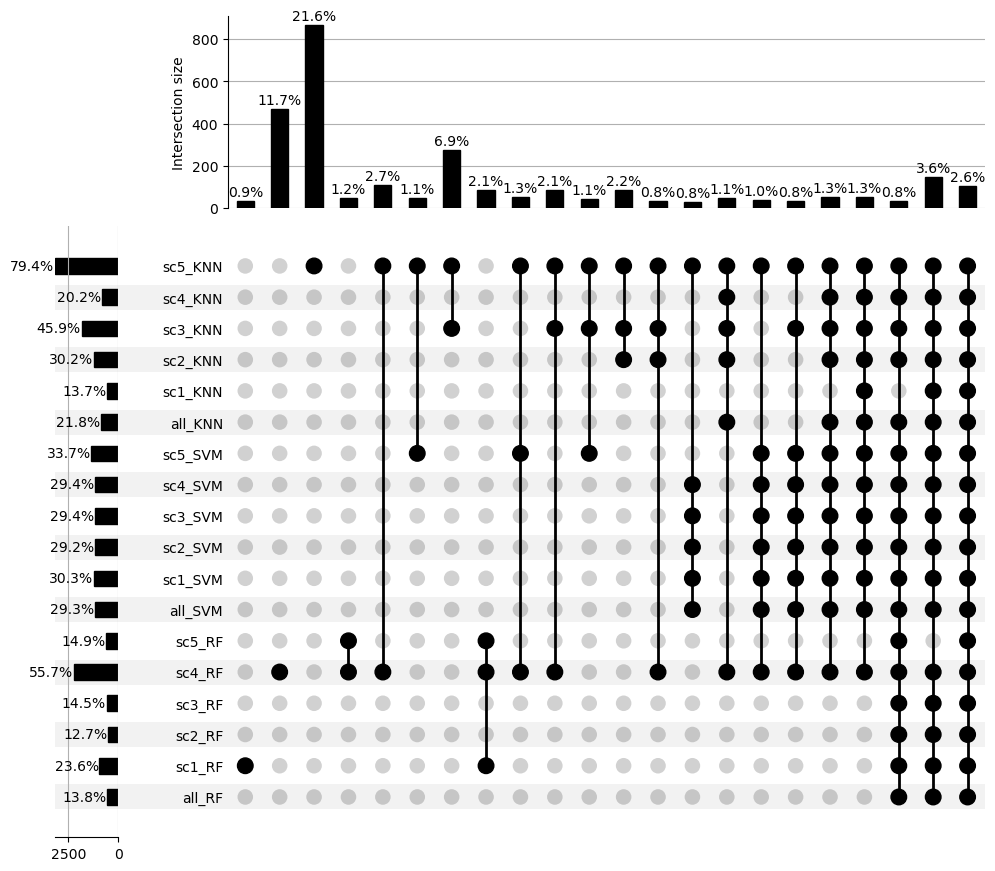

In [24]:
from upsetplot import plot
ax_dict = plot(para_upset_objeto, subset_size="count", min_subset_size=30, sort_categories_by = 'input', show_percentages = True).plot()


In [25]:
#predicciones por categoría

from collections import defaultdict

# Inicializar un diccionario para almacenar las predicciones por categoría
predicciones_por_categoria = defaultdict(list)

# Agrupar los modelos por categoría
for nombre_modelo, datos_modelo in modelos.items():
    categoria_modelo = nombre_modelo.split('_')[1]  # Obtener la categoría del nombre del modelo
    predicciones_modelo = datos_modelo['predicciones']
    predicciones_por_categoria[categoria_modelo].append(predicciones_modelo)

# Encontrar la intersección de las predicciones dentro de cada categoría
interseccion_predicciones_por_categoria = {}
for categoria, predicciones in predicciones_por_categoria.items():
    interseccion_predicciones = set.intersection(*map(set, predicciones))
    interseccion_predicciones_por_categoria[categoria] = interseccion_predicciones

# Ahora interseccion_predicciones_por_categoria contiene la intersección de las predicciones para cada categoría


C:\Users\masoz\anaconda3\lib\site-packages\upsetplot\data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
C:\Users\masoz\anaconda3\lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
C:\Users\

AttributeError: 'dict' object has no attribute 'plot'

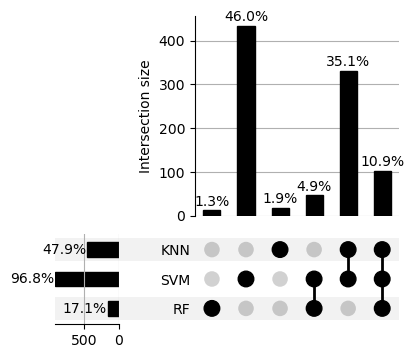

In [27]:
para_upset3_objeto = from_contents(interseccion_predicciones_por_categoria)
upset = UpSet(para_upset3_objeto)
# upset.plot()
ax_dict = plot(para_upset3_objeto, subset_size="count", sort_categories_by = 'input', show_percentages = True).plot()
# ax_dict.style_subsets(present=["SVM"], facecolor="blue", label="special")


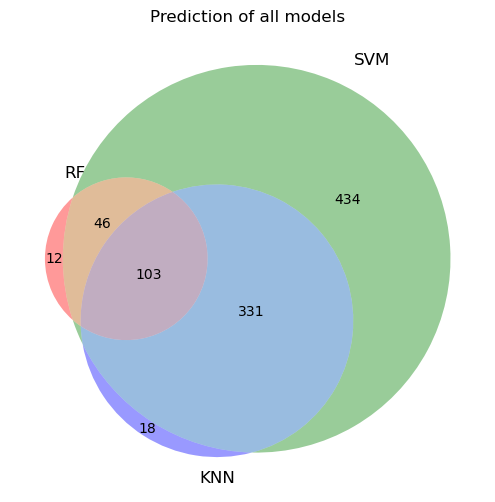

In [28]:
#Otra forma de ver la intersección de todos los modelos
from matplotlib import pyplot as plt
from matplotlib_venn import venn3

# Obtener las intersecciones de las predicciones por categoría
interseccion_RF = interseccion_predicciones_por_categoria.get('RF', set())
interseccion_SVM = interseccion_predicciones_por_categoria.get('SVM', set())
interseccion_KNN = interseccion_predicciones_por_categoria.get('KNN', set())

# Crear un diagrama de Venn
plt.figure(figsize=(8, 6))
venn3([interseccion_RF, interseccion_SVM, interseccion_KNN],
      set_labels=('RF', 'SVM', 'KNN'))

# Añadir título
plt.title("Prediction of all models")

# Mostrar el diagrama
plt.show()


## Chequear las predicciones de los genes duplicados

In [32]:
interseccion = interseccion_RF.intersection(interseccion_SVM).intersection(interseccion_KNN)
len(interseccion)
interseccion

{'WBGene00000063',
 'WBGene00000182',
 'WBGene00000183',
 'WBGene00000209',
 'WBGene00000210',
 'WBGene00000263',
 'WBGene00000378',
 'WBGene00000379',
 'WBGene00000534',
 'WBGene00000881',
 'WBGene00000896',
 'WBGene00001005',
 'WBGene00001393',
 'WBGene00001423',
 'WBGene00001427',
 'WBGene00001501',
 'WBGene00001840',
 'WBGene00001946',
 'WBGene00002191',
 'WBGene00003053',
 'WBGene00003065',
 'WBGene00003123',
 'WBGene00003214',
 'WBGene00003372',
 'WBGene00003962',
 'WBGene00004046',
 'WBGene00004266',
 'WBGene00004302',
 'WBGene00004444',
 'WBGene00004453',
 'WBGene00004497',
 'WBGene00004498',
 'WBGene00004766',
 'WBGene00004888',
 'WBGene00004914',
 'WBGene00004918',
 'WBGene00004920',
 'WBGene00006434',
 'WBGene00006910',
 'WBGene00006913',
 'WBGene00006917',
 'WBGene00006918',
 'WBGene00006919',
 'WBGene00006984',
 'WBGene00007630',
 'WBGene00007684',
 'WBGene00007708',
 'WBGene00009050',
 'WBGene00009664',
 'WBGene00009739',
 'WBGene00009880',
 'WBGene00009882',
 'WBGene0000

In [31]:
genes_duplicados = ['WBGene00015501', 'WBGene00013237', 'WBGene00006463', 'WBGene00022075',
'WBGene00016392', 'WBGene00013880', 'WBGene00019937', 'WBGene00012158', 'WBGene00011679', 'WBGene00020757',
'WBGene00044290', 'WBGene00013728', 'WBGene00000206', 'WBGene00000207', 'WBGene00019880', 'WBGene00022582',
                   'WBGene00018151', 'WBGene00007684', 'WBGene00015755', 'WBGene00009739', 'WBGene00018963',
                   'WBGene00019007', 'WBGene00017926', 'WBGene00000209', 'WBGene00000210', 'WBGene00017982']



In [34]:
# Verificar si alguno de los valores de genes_duplicados está en las listas de predicciones
for gen in genes_duplicados:
    cont = 0 
    for key, valor in modelos.items():
        if gen in valor['predicciones']:
            cont += 1
#     duplicados_df.loc[gen, 'Cantidad de veces predicho'] = cont
#             print('Gen', gen, 'en las predicciones en', key)
    print('El gen', gen, 'está presente en', cont, 'de 18 modelos')


El gen WBGene00015501 está presente en 1 de 18 modelos
El gen WBGene00013237 está presente en 17 de 18 modelos
El gen WBGene00006463 está presente en 2 de 18 modelos
El gen WBGene00022075 está presente en 17 de 18 modelos
El gen WBGene00016392 está presente en 1 de 18 modelos
El gen WBGene00013880 está presente en 0 de 18 modelos
El gen WBGene00019937 está presente en 6 de 18 modelos
El gen WBGene00012158 está presente en 17 de 18 modelos
El gen WBGene00011679 está presente en 6 de 18 modelos
El gen WBGene00020757 está presente en 1 de 18 modelos
El gen WBGene00044290 está presente en 0 de 18 modelos
El gen WBGene00013728 está presente en 11 de 18 modelos
El gen WBGene00000206 está presente en 7 de 18 modelos
El gen WBGene00000207 está presente en 17 de 18 modelos
El gen WBGene00019880 está presente en 0 de 18 modelos
El gen WBGene00022582 está presente en 0 de 18 modelos
El gen WBGene00018151 está presente en 18 de 18 modelos
El gen WBGene00007684 está presente en 18 de 18 modelos
El 

In [26]:
# # Abre el archivo en modo de escritura
with open('..\Archivos\Genes_predichos\interseccion_ds_todos.txt', 'w') as archivo:
    # Escribe cada elemento de la lista en una línea del archivo
    for elemento in interseccion:
        archivo.write(elemento + '\n')

# Abre el archivo en modo de escritura
with open('..\Archivos\Genes_predichos\interseccion_RF.txt', 'w') as archivo:
    # Escribe cada elemento de la lista en una línea del archivo
    for elemento in interseccion_RF:
        archivo.write(elemento + '\n')
        
# Abre el archivo en modo de escritura
with open('..\Archivos\Genes_predichos\interseccion_SVM.txt', 'w') as archivo:
    # Escribe cada elemento de la lista en una línea del archivo
    for elemento in interseccion_SVM:
        archivo.write(elemento + '\n')
# Abre el archivo en modo de escritura
with open('..\Archivos\Genes_predichos\interseccion_KNN.txt', 'w') as archivo:
    # Escribe cada elemento de la lista en una línea del archivo
    for elemento in interseccion_KNN:
        archivo.write(elemento + '\n')

## Enriquecimiento de la intersección

In [1]:
import pandas as pd

In [40]:
#Acá abrimos los genes de la intersección que guardamos antes pero con su código entrez para hacer GOEA
with open(r"..\Archivos\Genes_predichos\interseccion_ds_todos.txt", 'r') as file:
    # Read each line and store it in a list called 'predichos'
    interseccion = file.read().splitlines()

interseccion_df = pd.read_csv(r'..\Archivos\Genes_predichos\interseccion_todos_entrez.csv')
interseccion_entrez = list(interseccion_df['entrezgene_id'])

interseccion_RF_df = pd.read_csv(r'..\Archivos\Genes_predichos\interseccion_RF_entrezid.csv')
interseccion_RF_entrez = list(interseccion_RF_df['entrezgene_id'])

interseccion_SVM_df = pd.read_csv(r'..\Archivos\Genes_predichos\interseccion_SVM_entrezid.csv')
interseccion_SVM_entrez = list(interseccion_SVM_df['entrezgene_id'])

interseccion_KNN_df = pd.read_csv(r'..\Archivos\Genes_predichos\interseccion_KNN_entrezid.csv')
interseccion_KNN_entrez = list(interseccion_SVM_df['entrezgene_id'])

all_genes_celegans = pd.read_csv(r'..\Archivos\Genes_predichos\all_genes_entrez.csv')
all_genes_celegans_entrez = list(all_genes_celegans['entrezgene_id'])

In [41]:
len(interseccion_entrez)

103

In [45]:
#Acá usamos el la función download_go_basic_obo, que nos permite bajar el archivo OBO de GO. 
#El archivo OBO ya existe dentro de esta carpeta, por lo que solo lo lee. 
# Get http://geneontology.org/ontology/go-basic.obo
from goatools.base import download_go_basic_obo
obo_fname = download_go_basic_obo()

  EXISTS: go-basic.obo


In [48]:
#Hace lo mismo con el archivo gene2go
# Get ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz
from goatools.base import download_ncbi_associations
file_gene2go = download_ncbi_associations()

  EXISTS: gene2go


In [46]:
from goatools.obo_parser import GODag

obodag = GODag("go-basic.obo")

go-basic.obo: fmt(1.2) rel(2024-01-17) 45,869 Terms


In [49]:
from __future__ import print_function
from goatools.anno.genetogo_reader import Gene2GoReader

# Read NCBI's gene2go. Store annotations in a list of namedtuples
#taxid = 6239 == c elegans
objanno = Gene2GoReader(file_gene2go, taxids=[6239])

# Get associations for each branch of the GO DAG (BP, MF, CC)
ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated celegans genes".format(NS=nspc, N=len(id2gos)))

HMS:0:02:13.188418 104,661 annotations, 14,154 genes,  6,853 GOs, 1 taxids READ: gene2go 
CC 12,331 annotated celegans genes
BP 9,677 annotated celegans genes
MF 9,502 annotated celegans genes


In [50]:
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

goeaobj = GOEnrichmentStudyNS(
        all_genes_celegans_entrez, # List of mouse protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['bonferroni', 'fdr_bh']) # defult multipletest correction method        methods = []) # defult multipletest correction method


Load BP Ontology Enrichment Analysis ...
 21%  9,664 of 46,923 population items found in association

Load CC Ontology Enrichment Analysis ...
 26% 12,322 of 46,923 population items found in association

Load MF Ontology Enrichment Analysis ...
 20%  9,491 of 46,923 population items found in association


In [54]:
GOEA_RF = goeaobj.run_study(interseccion_RF_entrez)
goea_results_sig_RF = [r for r in GOEA_RF if r.p_fdr_bh < 0.05]
GOEA_SVM = goeaobj.run_study(interseccion_SVM_entrez) 
goea_results_sig_SVM = [r for r in GOEA_SVM if r.p_fdr_bh < 0.05]
GOEA_KNN = goeaobj.run_study(interseccion_KNN_entrez) 
goea_results_sig_KNN = [r for r in GOEA_KNN if r.p_fdr_bh < 0.05]
results = goeaobj.run_study(interseccion_entrez)
goea_results_sig = [r for r in results if r.p_fdr_bh < 0.05]


Runing BP Ontology Analysis: current study set of 161 IDs.
 78%    125 of    160 study items found in association
 99%    160 of    161 study items found in population(46923)
Calculating 3,677 uncorrected p-values using fisher_scipy_stats
   3,677 terms are associated with  9,663 of 46,923 population items
     289 terms are associated with    125 of    161 study items
  METHOD bonferroni:
      19 GO terms found significant (< 0.05=alpha) ( 19 enriched +   0 purified): local bonferroni
      78 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
  METHOD fdr_bh:
      44 GO terms found significant (< 0.05=alpha) ( 44 enriched +   0 purified): statsmodels fdr_bh
      96 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 161 IDs.
 89%    142 of    160 study items found in association
 99%  

In [62]:
goeaobj.wr_xlsx(r"..\Archivos\GOEA_results\GOEA_result_RF.xlsx", goea_results_sig_RF)
goeaobj.wr_xlsx("..\Archivos\GOEA_results\GOEA_result_SVM.xlsx", goea_results_sig_SVM)
goeaobj.wr_xlsx("..\Archivos\GOEA_results\GOEA_result_KNN.xlsx", goea_results_sig_KNN)
goeaobj.wr_xlsx("..\Archivos\GOEA_results\GOEA_result.xlsx", goea_results_sig)

    137 items WROTE: ..\Archivos\GOEA_result_RF.xlsx
    595 items WROTE: ..\Archivos\GOEA_result_SVM.xlsx
    595 items WROTE: ..\Archivos\GOEA_result_KNN.xlsx
     80 items WROTE: ..\Archivos\GOEA_result.xlsx


In [65]:
GOEA_result = pd.read_csv(r'..\Archivos\GOEA_results\GOEA_result.csv', sep = ';')
GOEA_result_RF = pd.read_csv(r'..\Archivos\GOEA_results\GOEA_result_RF.csv', sep = ';')
GOEA_result_SVM = pd.read_csv(r'..\Archivos\GOEA_results\GOEA_result_SVM.csv', sep = ';')
GOEA_result_KNN = pd.read_csv(r'..\Archivos\GOEA_results\GOEA_result_KNN.csv', sep = ';')

In [66]:
# Convierte las cadenas en números
GOEA_result['ratio_in_study_num'] = GOEA_result['ratio_in_study'].apply(lambda x: eval(x))
GOEA_result['ratio_in_pop_num'] = GOEA_result['ratio_in_pop'].apply(lambda x: eval(x))
# Calcula el enriquecimiento y agrega una nueva columna llamada 'enrichment'
GOEA_result['fold_enrichment'] = GOEA_result['ratio_in_study_num'] / GOEA_result['ratio_in_pop_num']

# Convierte las cadenas en números
GOEA_result_RF['ratio_in_study_num'] = GOEA_result_RF['ratio_in_study'].apply(lambda x: eval(x))
GOEA_result_RF['ratio_in_pop_num'] = GOEA_result_RF['ratio_in_pop'].apply(lambda x: eval(x))
# Calcula el enriquecimiento y agrega una nueva columna llamada 'enrichment'
GOEA_result_RF['fold_enrichment'] = GOEA_result_RF['ratio_in_study_num'] / GOEA_result_RF['ratio_in_pop_num']

# Convierte las cadenas en números
GOEA_result_SVM['ratio_in_study_num'] = GOEA_result_SVM['ratio_in_study'].apply(lambda x: eval(x))
GOEA_result_SVM['ratio_in_pop_num'] = GOEA_result_SVM['ratio_in_pop'].apply(lambda x: eval(x))
# Calcula el enriquecimiento y agrega una nueva columna llamada 'enrichment'
GOEA_result_SVM['fold_enrichment'] = GOEA_result_SVM['ratio_in_study_num'] / GOEA_result_SVM['ratio_in_pop_num']

# Convierte las cadenas en números
GOEA_result_KNN['ratio_in_study_num'] = GOEA_result_KNN['ratio_in_study'].apply(lambda x: eval(x))
GOEA_result_KNN['ratio_in_pop_num'] = GOEA_result_KNN['ratio_in_pop'].apply(lambda x: eval(x))
# Calcula el enriquecimiento y agrega una nueva columna llamada 'enrichment'
GOEA_result_KNN['fold_enrichment'] = GOEA_result_KNN['ratio_in_study_num'] / GOEA_result_KNN['ratio_in_pop_num']


In [70]:
# Lista de los nombres de los DataFrames y sus etiquetas correspondientes
dataframes = [
    (GOEA_result_RF, 'RF'),
    (GOEA_result_SVM, 'SVM'),
    (GOEA_result_KNN, 'KNN')
]

# Crear una lista para almacenar los índices de las filas que cumplen la condición
filas_mayor_enrichment = []

# Iterar sobre cada fila del DataFrame base (GOEA_result) para comparar con los otros DataFrames
for indice, fila in GOEA_result.iterrows():
    fold_enrichment_base = fila['fold_enrichment']
    mayor_en_otro_df = True
    
    # Comparar con cada otro DataFrame
    for otro_df, _ in dataframes:
        fold_enrichment_otro_df = otro_df.loc[indice, 'fold_enrichment']
        
        # Si el valor en el otro DataFrame es mayor o igual, no cumple la condición
        if fold_enrichment_base <= fold_enrichment_otro_df:
            mayor_en_otro_df = False
            break
    
    # Si la fila cumple la condición para todos los DataFrames, agregar su índice a la lista
    if mayor_en_otro_df:
        filas_mayor_enrichment.append(GOEA_result.loc[indice, 'name'])

# Imprimir los índices de las filas que cumplen la condición
print("Filas con mayor 'fold_enrichment' que en los otros DataFrames:")
print(filas_mayor_enrichment)


Filas con mayor 'fold_enrichment' que en los otros DataFrames:
['proton transmembrane transport', 'RNA splicing', 'ribosome biogenesis', 'mitochondrial electron transport, ubiquinol to cytochrome c', 'proton motive force-driven ATP synthesis', 'snRNA pseudouridine synthesis', 'rRNA pseudouridine synthesis', 'regulation of syncytium formation by plasma membrane fusion', 'lysosomal lumen acidification', 'purine nucleobase metabolic process', 'electron transport chain', 'nuclear mRNA surveillance', 'box C/D RNP complex', 'nucleolus', 'mitochondrial respiratory chain complex III', 'mitochondrial inner membrane', 'small-subunit processome', 'cytosolic large ribosomal subunit', 'U1 snRNP', 'vacuolar proton-transporting V-type ATPase, V1 domain', 'box H/ACA snoRNP complex', 'proton-transporting two-sector ATPase complex, proton-transporting domain', 'SMN-Sm protein complex', 'pICln-Sm protein complex', 'spliceosomal tri-snRNP complex', 'U12-type spliceosomal complex', 'U4 snRNP', 'mitochondri

In [71]:
gos_seleccionados = ['GO:1902600', #proton transmembrane transport
                     'GO:0005743', #mitochondrial inner membrane
                     'GO:0015986', #proton motive force-driven ATP synthesis
                     'GO:0007042', #lysosomal lumen acidification
                     'GO:0015986', #proton motive force-driven ATP synthesis
                     'GO:0005739', #mitochondrion
                     'GO:0016020', #membrane
                     'GO:0005524'] #ATP binding
# Convertir gos_seleccionados a un conjunto para mejorar la eficiencia
gos_seleccionados_set = set(gos_seleccionados)


In [72]:
for i in gos_seleccionados_set:
    if i not in list(GOEA_result_RF['GO']):
        print(i, 'No en RF')
    elif i not in list(GOEA_result_SVM['GO']):
        print(i, 'No en SVM')
    elif i not in list(GOEA_result_KNN['GO']):
        print(i, 'No en KNN')

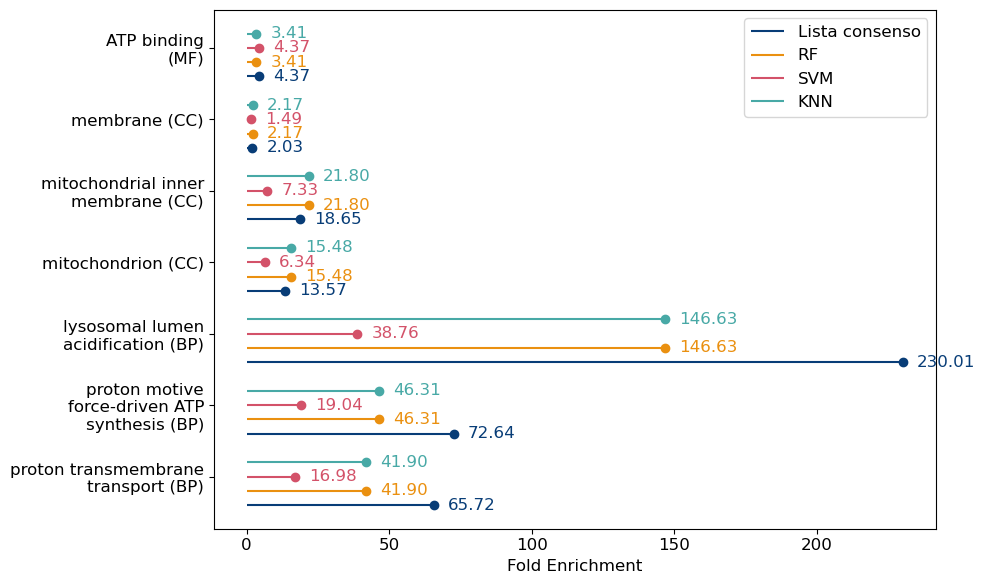

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Configurar el tamaño de la fuente globalmente
plt.rc('font', size=12)  # Ajusta el tamaño de la fuente según sea necesario
# plt.rc('axes', titlesize=12)  # Tamaño de la fuente para el título de los ejes
plt.rc('axes', labelsize=12)  # Tamaño de la fuente para las etiquetas de los ejes
# plt.rc('xtick', labelsize=12)  # Tamaño de la fuente para las etiquetas del eje x
# plt.rc('ytick', labelsize=12)  # Tamaño de la fuente para las etiquetas del eje y
# plt.rc('legend', fontsize=12)  # Tamaño de la fuente para la leyenda

# Lista de los DataFrames y sus etiquetas correspondientes
dataframes = [
    (GOEA_result, 'Lista consenso'),
    (GOEA_result_RF, 'RF'),
    (GOEA_result_SVM, 'SVM'),
    (GOEA_result_KNN, 'KNN')
]

# Filtrar cada DataFrame para que solo contenga las filas cuyo valor en la columna 'GO' coincida con los valores de gos_seleccionados
dataframes_filtrados = [(df[df['GO'].isin(gos_seleccionados)], label) for df, label in dataframes]

# Colores para cada DataFrame
colors = ['#083D77', '#EA9010', '#D35269', '#48A9A6']

# Función para insertar un salto de línea después de cada dos palabras
def insert_line_breaks(text):
    words = text.split()
    return '\n'.join([' '.join(words[i:i+2]) for i in range(0, len(words), 2)])

# Crear la gráfica
fig, ax = plt.subplots(figsize=(10, 6))

# Calcular el número de DataFrames
num_dataframes = len(dataframes_filtrados)

# Loop a través de cada DataFrame filtrado
for i, ((df, label), color) in enumerate(zip(dataframes_filtrados, colors)):
    go_values = df.apply(lambda x: f"{x['name']} ({x['NS']})", axis=1).values
    go_values = [insert_line_breaks(go) for go in go_values]
    fold_enrichment_values = df['fold_enrichment'].values
    p_fdr_bh_values = df['p_fdr_bh'].values

    # Convertir los valores de GO a una representación numérica para el eje y
    y = np.arange(len(go_values))

    # Aplicar un offset a los valores y para evitar superposición
    offset = (i - num_dataframes / 2) * 0.2

    # Graficar las líneas lollipop horizontalmente
    ax.hlines(y + offset, xmin=0, xmax=fold_enrichment_values, color=color, label=label)
    ax.plot(fold_enrichment_values, y + offset, "o", color=color)
    
    # Agregar el valor al lado de cada punto, moviéndolo un poco a la derecha
    for j in range(len(fold_enrichment_values)):
        ax.text(fold_enrichment_values[j] + 5, y[j] + offset, f'{fold_enrichment_values[j]:.2f}', 
                color=color, va='center', ha='left', fontsize=12)

# Personalizar la gráfica
ax.set_yticks(np.arange(len(go_values)))
ax.set_yticklabels(go_values)
# ax.set_title('Lollipop Plot with Multiple Series')
ax.set_xlabel('Fold Enrichment')
ax.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()